## **ASSIGNMENT 3**: Performing KNN on the Iris Dataset

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
import time

In [2]:
iris = load_iris()

In [3]:
X = iris.data
y = iris.target

In [4]:
df = pd.DataFrame(X, columns=iris.feature_names)
df["species"] = y

In [5]:
df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


### **Petal Width vs. Petal Length**: I'm choosing these features to predict the label because they cluster the data in the best way. In other words, the clearest differences between species can be observed by plotting these 2 features together.

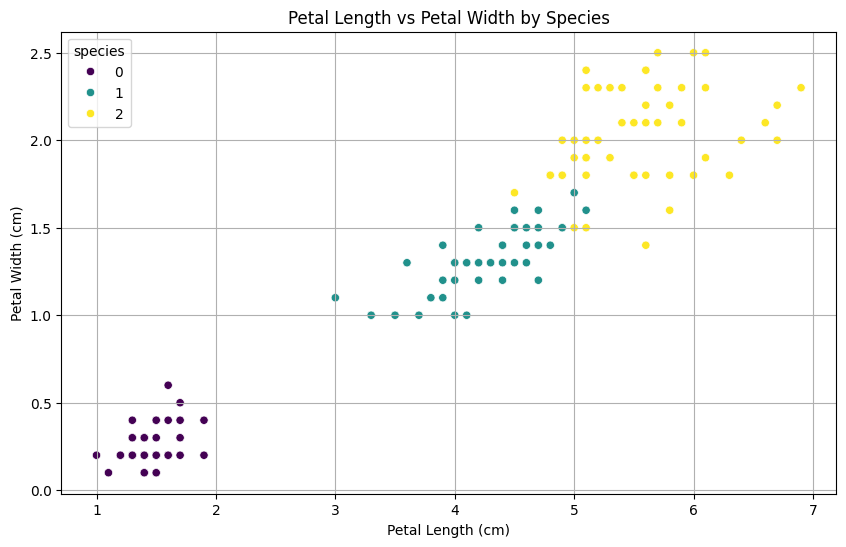

In [6]:
# scatter plot petal_length vs petal_width colored by species
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='petal length (cm)', y='petal width (cm)', hue='species', palette = 'viridis')
plt.title('Petal Length vs Petal Width by Species')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.grid(True)
plt.show()

In [7]:
# standardizing the features that I will use
scaler = MinMaxScaler()
df[['petal length (cm)', 'petal width (cm)']] = scaler.fit_transform(df[['petal length (cm)', 'petal width (cm)']])

print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5           0.067797          0.041667   
1                4.9               3.0           0.067797          0.041667   
2                4.7               3.2           0.050847          0.041667   
3                4.6               3.1           0.084746          0.041667   
4                5.0               3.6           0.067797          0.041667   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  


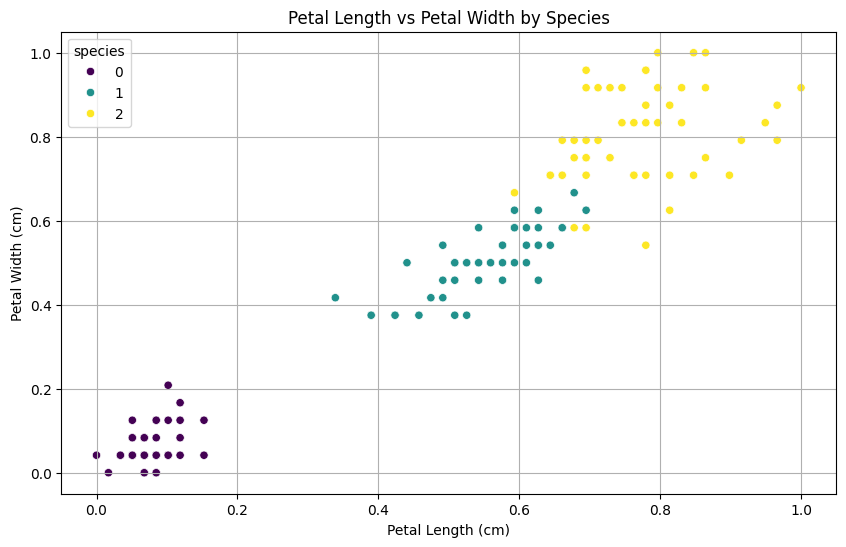

In [8]:
# scatter plot petal_length vs petal_width colored by species
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='petal length (cm)', y='petal width (cm)', hue='species', palette = 'viridis')
plt.title('Petal Length vs Petal Width by Species')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.grid(True)
plt.show()

In [9]:
df["species"].value_counts()

species
0    50
1    50
2    50
Name: count, dtype: int64

### Implementing the **"manual" model** :)

In [10]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def manhattan_distance(p1, p2):
    return np.sum(np.abs(p1 - p2))

def bubble_sort(distances):
    n = len(distances)
    for i in range(n):
        for j in range(0, n-i-1):
            if distances[j][0] > distances[j+1][0]:
                distances[j], distances[j+1] = distances[j+1], distances[j]
    return distances

def majority_vote(distances, k):
    neighbors = [label for (_, label) in distances[:k]]
    vote_counts = Counter(neighbors)
    max_count = max(vote_counts.values())
    winners = [label for label, count in vote_counts.items() if count == max_count]
    
    if len(winners) == 1:
        return winners[0]
    else:
        for dist, label in distances[:k]:
            if label in winners:
                return label

def knn(x_test, X_train, y_train, k=1, distance_metric="euclidean"):
    distances=[]
    for i in range(len(X_train)):
        if distance_metric == "euclidean":
            distance = euclidean_distance(x_test, X_train[i])
        elif distance_metric == "manhattan":
            distance = manhattan_distance(x_test, X_train[i])
        else:
            raise ValueError("Unknown distance metric. Use 'euclidean' or 'manhattan'.")

        distances.append((distance, y_train[i]))

    distances = bubble_sort(distances)

    prediction = majority_vote(distances, k)

    return prediction


def loocv(X, y, k=1, distance_metric="euclidean"):
    samples = X.shape[0]
    y_pred = []

    start_time = time.time()
    
    for i in range(samples):
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i, axis=0)
        x_test = X[i]

        pred = knn(x_test, X_train, y_train, k=k, distance_metric=distance_metric)
        y_pred.append(pred)

    run_time = time.time() - start_time

    return np.array(y), np.array(y_pred), run_time

def evaluate_model(y_true, y_pred, average='macro'):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average=average) * 100
    recall = recall_score(y_true, y_pred, average=average) * 100

    correct = np.sum(y_true == y_pred)
    incorrect = len(y_true) - correct
 
    print("===== Evaluation Metrics =====")
    print(f"Correct: {correct}, Incorrect: {incorrect}")
    print(f"Accuracy : {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall   : {recall:.2f}%")
    print("=================================")
    
    return accuracy, precision, recall, correct, incorrect


def plot_predictions(X, y_true, y_pred, k, feature_names=['petal length (cm)', 'petal width (cm)']):
    X_np = np.array(X)
    
    plt.figure(figsize=(10,6))
    
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            plt.scatter(X_np[i, 0], X_np[i, 1], c='green', marker='o', label="Correct", alpha=0.5)
        else:
            plt.scatter(X_np[i, 0], X_np[i, 1], c='red', marker='x', label="Incorrect", alpha=0.5)
    
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f"kNN Predictions for k={k}")
    plt.grid(True)
    plt.show()


In [11]:
X = df[['petal length (cm)', 'petal width (cm)']].values
y = df['species'].values
k_values = [1, 3, 5, 7]


Testing with Euclidean distance:

--- k = 1 ---
===== Evaluation Metrics =====
Correct: 144, Incorrect: 6
Accuracy : 96.00%
Precision: 96.05%
Recall   : 96.00%
Execution time: 0.1661


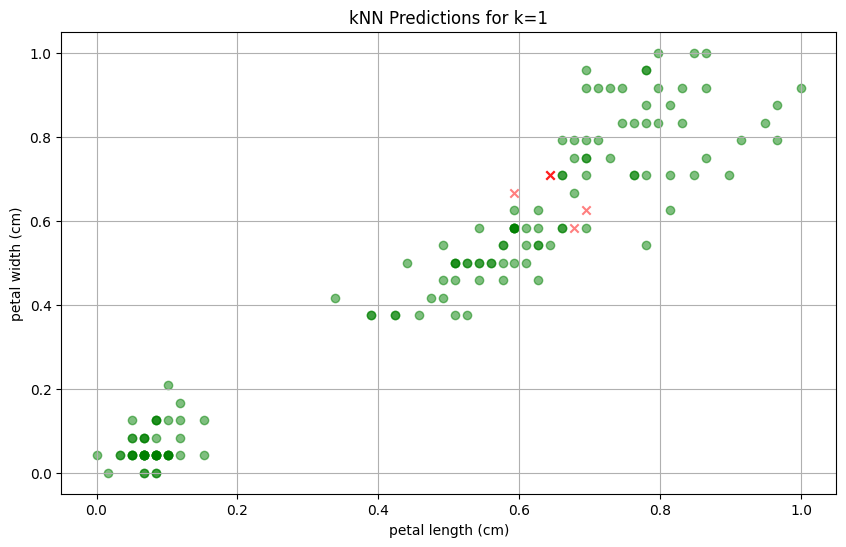


--- k = 3 ---
===== Evaluation Metrics =====
Correct: 142, Incorrect: 8
Accuracy : 94.67%
Precision: 94.71%
Recall   : 94.67%
Execution time: 0.1524


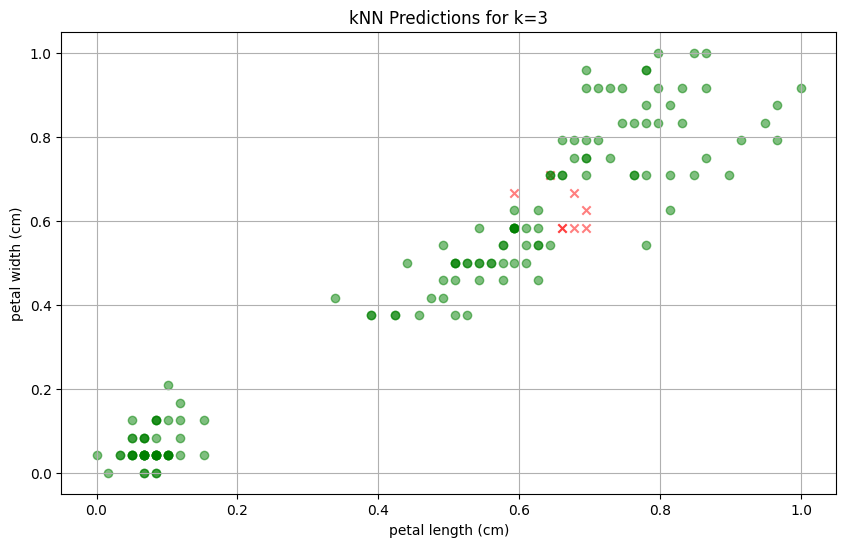


--- k = 5 ---
===== Evaluation Metrics =====
Correct: 145, Incorrect: 5
Accuracy : 96.67%
Precision: 96.68%
Recall   : 96.67%
Execution time: 0.1601


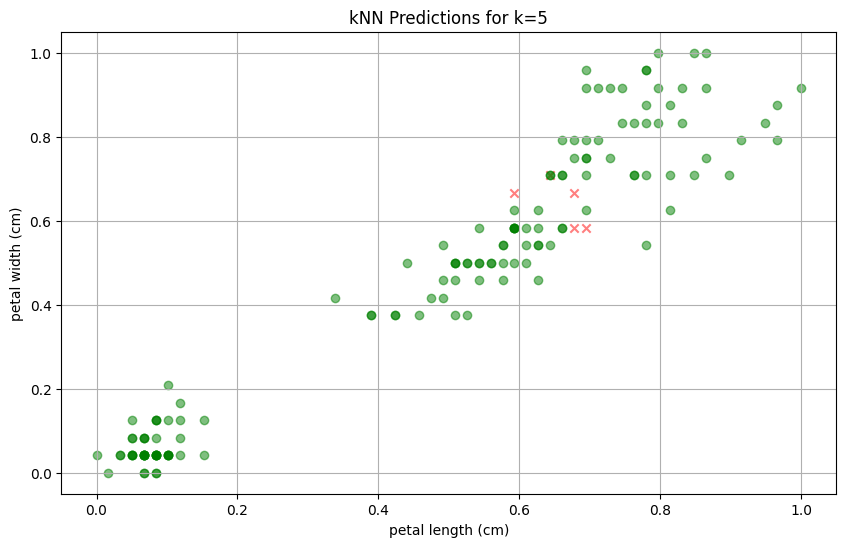


--- k = 7 ---
===== Evaluation Metrics =====
Correct: 145, Incorrect: 5
Accuracy : 96.67%
Precision: 96.68%
Recall   : 96.67%
Execution time: 0.1605


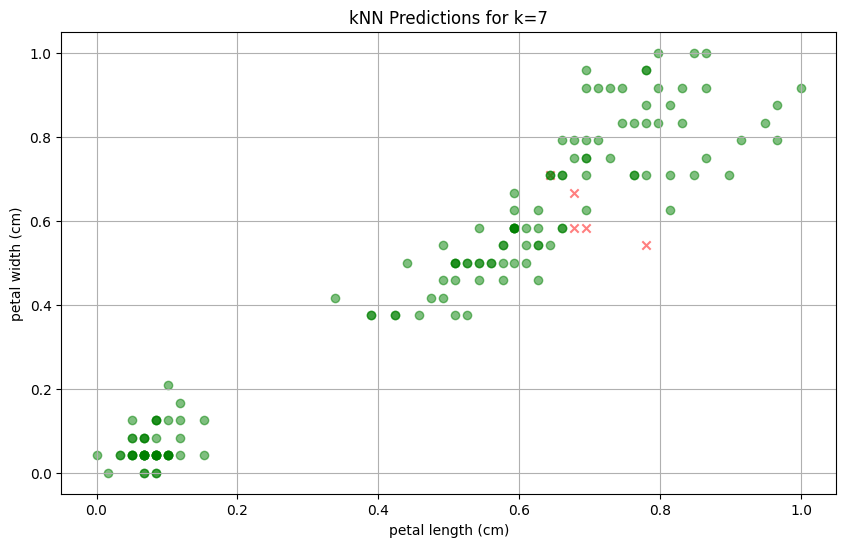

In [12]:
print("Testing with Euclidean distance:")
for k in k_values:
    print(f"\n--- k = {k} ---")
    y_true, y_pred, run_time = loocv(X, y, k=k, distance_metric="euclidean")
    evaluate_model(y_true, y_pred)
    print(f"Execution time: {run_time:.4f}")
    plot_predictions(X, y_true, y_pred, k)

Testing with Manhattan distance:

--- k = 1 ---
===== Evaluation Metrics =====
Correct: 144, Incorrect: 6
Accuracy : 96.00%
Precision: 96.05%
Recall   : 96.00%
Execution time: 0.1414


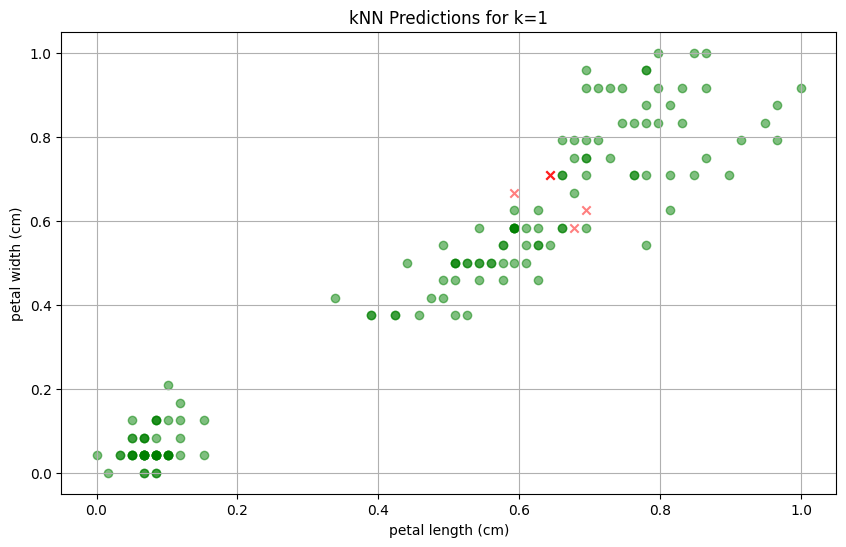


--- k = 3 ---
===== Evaluation Metrics =====
Correct: 142, Incorrect: 8
Accuracy : 94.67%
Precision: 94.71%
Recall   : 94.67%
Execution time: 0.1433


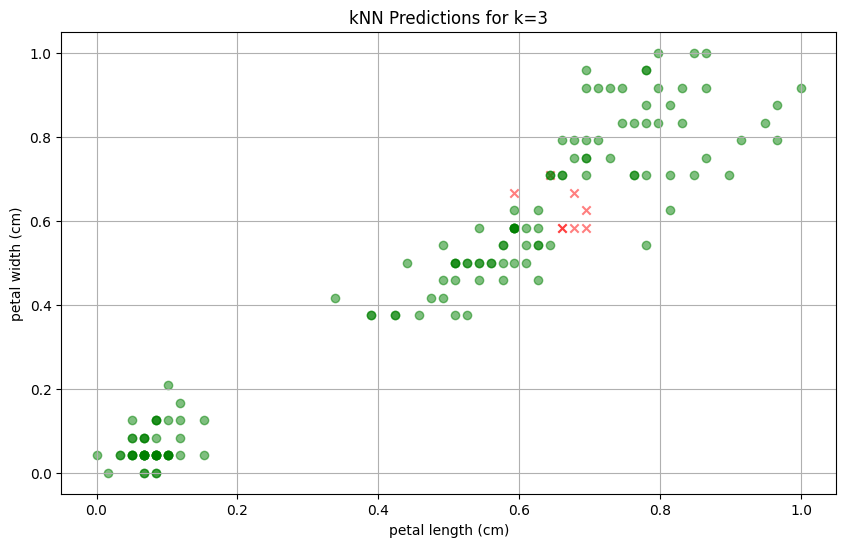


--- k = 5 ---
===== Evaluation Metrics =====
Correct: 145, Incorrect: 5
Accuracy : 96.67%
Precision: 96.68%
Recall   : 96.67%
Execution time: 0.1378


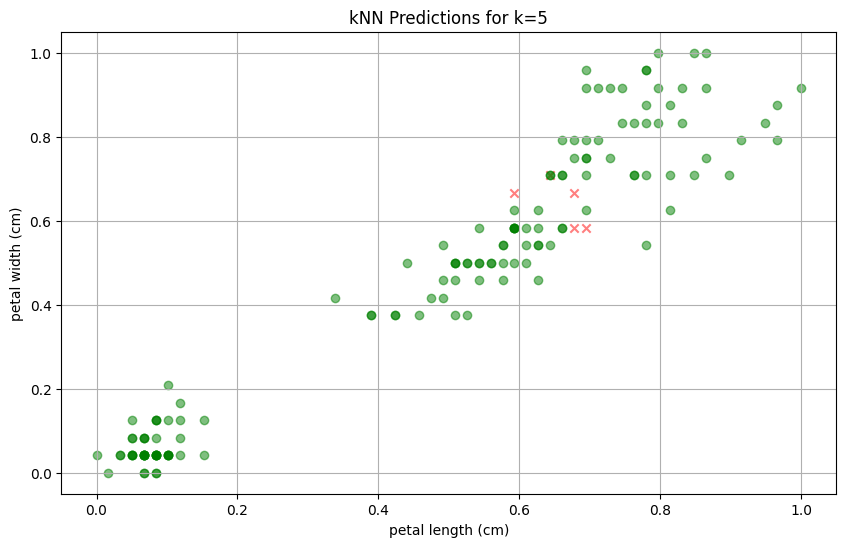


--- k = 7 ---
===== Evaluation Metrics =====
Correct: 144, Incorrect: 6
Accuracy : 96.00%
Precision: 96.05%
Recall   : 96.00%
Execution time: 0.1434


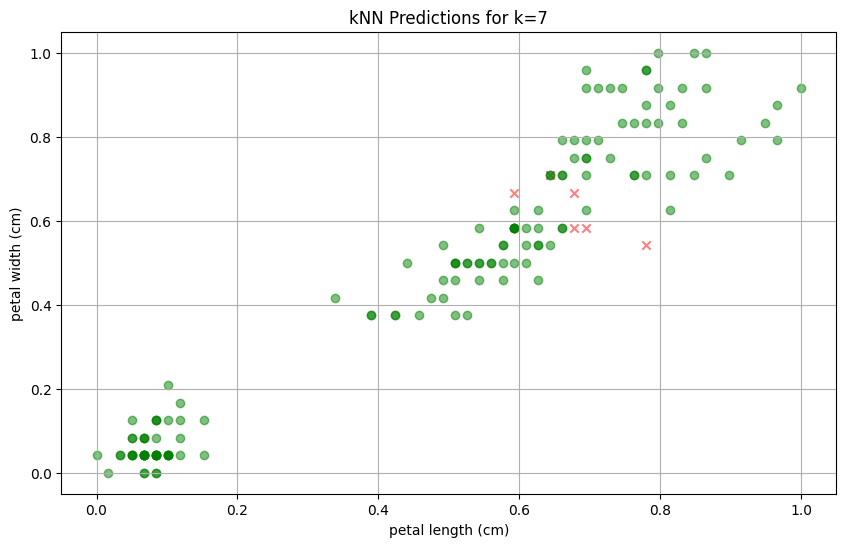

In [13]:
print("Testing with Manhattan distance:")
for k in k_values:
    print(f"\n--- k = {k} ---")
    y_true, y_pred, run_time = loocv(X, y, k=k, distance_metric="manhattan")
    evaluate_model(y_true, y_pred)
    print(f"Execution time: {run_time:.4f}")
    plot_predictions(X, y_true, y_pred, k)

### Implementing the **Scikit model**

In [14]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

def sklearn_knn(X, y, k=1, distance_metric="euclidean"):
    loocv = LeaveOneOut()
    y_true, y_pred = [], []
    
    knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
    
    start_time = time.time()
    
    for train_index, test_index in loocv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)
        
        y_true.append(y_test[0])
        y_pred.append(pred[0])
    
    run_time = time.time() - start_time
    
    return np.array(y_true), np.array(y_pred), run_time


===== Evaluation Metrics =====
Correct: 145, Incorrect: 5
Accuracy : 96.67%
Precision: 96.68%
Recall   : 96.67%
Execution time: 0.1548


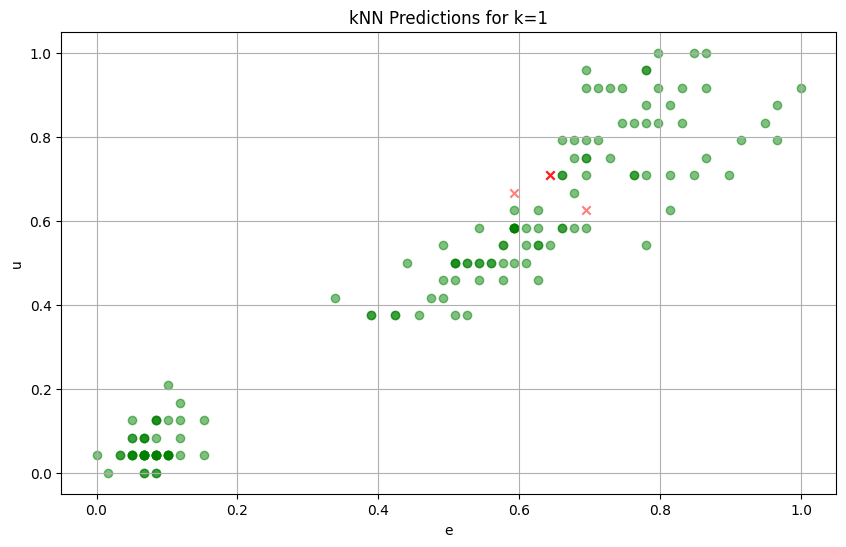

In [15]:
y_true, y_pred, run_time = sklearn_knn(X, y, 1, "euclidean")
evaluate_model(y_true, y_pred)
print(f"Execution time: {run_time:.4f}")
plot_predictions(X, y_true, y_pred, 1, "euclidean")

===== Evaluation Metrics =====
Correct: 142, Incorrect: 8
Accuracy : 94.67%
Precision: 94.71%
Recall   : 94.67%
Execution time: 0.1386


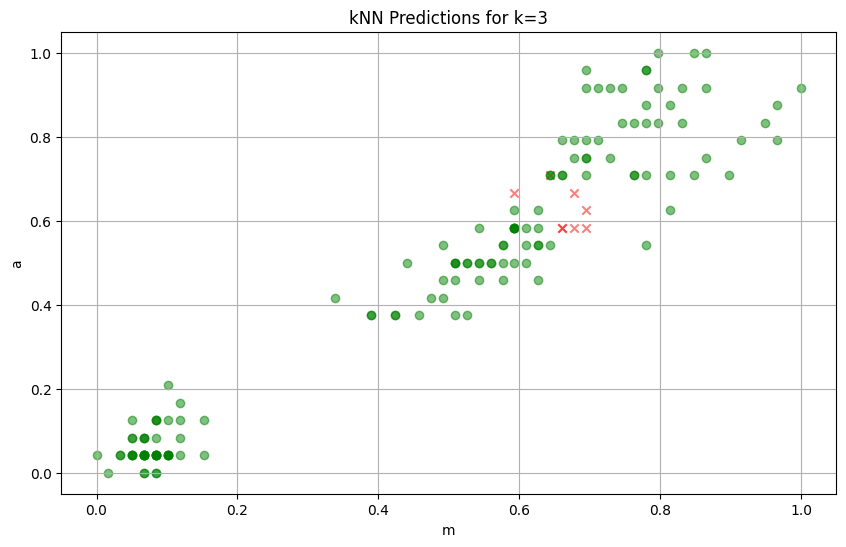

In [16]:
y_true, y_pred, run_time = sklearn_knn(X, y, 3, "manhattan")
evaluate_model(y_true, y_pred)
print(f"Execution time: {run_time:.4f}")
plot_predictions(X, y_true, y_pred, 3, "manhattan")

===== Evaluation Metrics =====
Correct: 145, Incorrect: 5
Accuracy : 96.67%
Precision: 96.68%
Recall   : 96.67%
Execution time: 0.1299


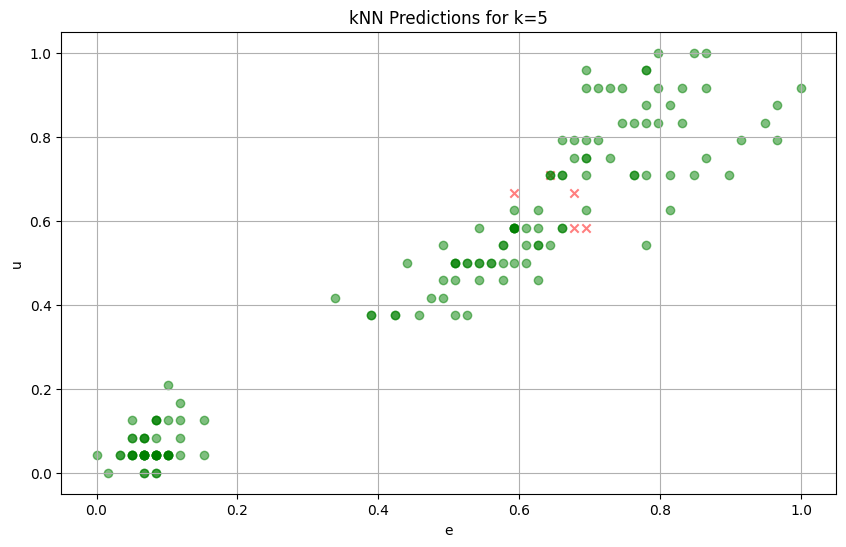

In [17]:
y_true, y_pred, run_time = sklearn_knn(X, y, 5, "euclidean")
evaluate_model(y_true, y_pred)
print(f"Execution time: {run_time:.4f}")
plot_predictions(X, y_true, y_pred, 5, "euclidean")

===== Evaluation Metrics =====
Correct: 144, Incorrect: 6
Accuracy : 96.00%
Precision: 96.05%
Recall   : 96.00%
Execution time: 0.1316


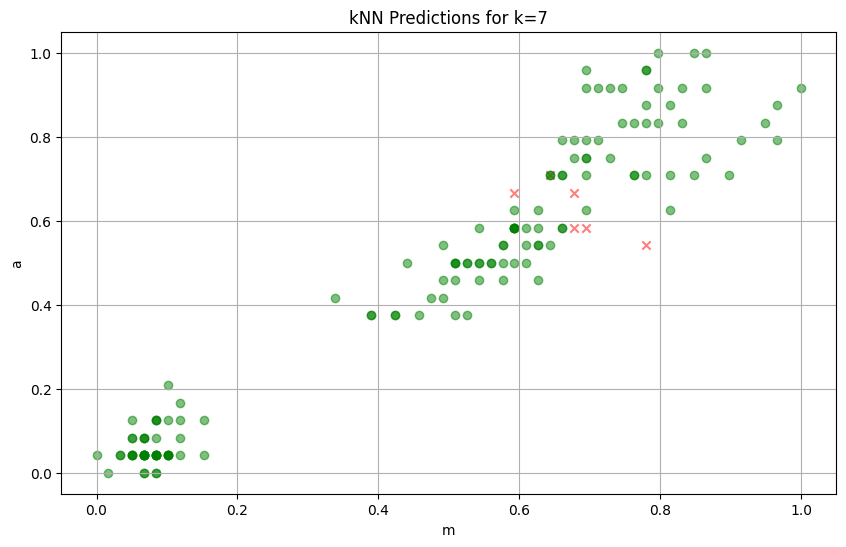

In [18]:
y_true, y_pred, run_time = sklearn_knn(X, y, 7, "manhattan")
evaluate_model(y_true, y_pred)
print(f"Execution time: {run_time:.4f}")
plot_predictions(X, y_true, y_pred, 7, "manhattan")